# Setup Imports

In [13]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *
import solarpanels
import pprint

# Setup Locations and Weather

We evaluate 13 locations using PSM3 5 minute data for 2022 to obtain the dimmest day out of the 13, the hottest day of the 13, and the calmest day of the 13.  We then impose that horid weather on Hood River, on the December 2022 solstice from sunrise to sunset.

In [14]:
# setup locations
locations = {}

#latitude, longitude, name, altitude, timezone
locations['Hood River'] = (45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8')
locations['Albuquerque'] = (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7')
locations['San Francisco'] = (37.7749, -122.4194, 'San Francisco', 61, 'Etc/GMT+8')
locations['Miami'] = (25.7617, -80.1918, 'Miami', 2, 'Etc/GMT+5')
locations['Denver'] = (39.7, -105.0, 'Denver', 1600, 'Etc/GMT+7')
locations['Phoenix'] = (33.5, -112.0, 'Phoenix', 340, 'Etc/GMT+7')
locations['Los Angeles'] = (34.0522, -118.2437, 'Los Angeles', 85, 'Etc/GMT+8')
locations['San Antonio'] = (29.4241, -98.4936, 'San Antonio', 200, 'Etc/GMT+6')
locations['Washington'] = (38.9072, -77.0369, 'Washington', 10, 'Etc/GMT+5')
locations['Cincinnati'] = (39.1031, -84.512, 'Cincinnati', 150, 'Etc/GMT+5')
locations['Hatteras'] = (35.2, -75.7, 'Hatteras', 1, 'Etc/GMT+5')
locations['Key West'] = (24.6, -81.8, 'Key West', 1, 'Etc/GMT+5')
locations['Death Valley'] = (36.46301553642297, -116.87362879671764, 'Death Valley', -60, 'Etc/GMT+8')

In [15]:
# read files and setup weather
weathers = {}
for location in locations:
    names = '2022'
    filename = 'psm3_' + location + '_' + names + '.csv'
    weathers[location] = pd.read_csv(filename, index_col=0, parse_dates=True)

## Iterate over Locations and Days to determine the hottest, dimmest, and calmest days


In [16]:
# extemes is a dict of the form 
# {location: {'hottest': {'temperature': temperature, 'sunrise': sunrise, 'sunset':sunset}, 'coldest':{...}, 'brightest':{...} dimmest': {...}, 'windiest': {...},'calmest_day': {}}}
extremes = {}

for location in locations:
    #print(location)
    # create location object
    lat, lon, name, alt, tz = locations[location]
    pvlocation = Location(lat, lon, name=name, altitude=alt, tz=tz)
    weather = weathers[location]

    # iterate over dates
    dates = pd.date_range(start='2022-01-01', end='2022-12-31', tz=pvlocation.tz)
    for date in dates:
        #print(date)
        date_index = pd.DatetimeIndex([date])
        
        # Get the sunrise and sunset times for the date
        sun_times = pvlocation.get_sun_rise_set_transit(date_index)
        
        # Extract the sunrise and sunset times
        sunrise = sun_times['sunrise'].iloc[0]
        sunset = sun_times['sunset'].iloc[0]
        
        # Slice DataFrames to the range from sunrise to sunset
        weather_slice = weather.loc[sunrise:sunset]

        # Calculate extremes for the slice/day by averaging the appropriate column
        temperature = weather_slice['temp_air'].sum()/len(weather_slice)
        irradiance = weather_slice['ghi'].sum()/len(weather_slice)
        wind_speed = weather_slice['wind_speed'].sum()/len(weather_slice)
        
        date_string = sunrise.strftime('%Y-%m-%d')
        #print the location, date, and irradiance, the sum of ghi, and the length of the slice
        #print(location, ' ', date_string, ' irradiance=', irradiance, 'ghi sum=', weather_slice['ghi'].sum(), 'length of slice=', len(weather_slice))
        


        # Update the extremes dictionary
        if location not in extremes:
            #print('location not in extremes')
            extremes[location] = {'hottest': {'temperature': temperature, 'sunrise': sunrise, 'sunset':sunset}, 'coldest': {'temperature': temperature, 'sunrise': sunrise, 'sunset':sunset}, 'brightest': {'irradiance': irradiance, 'sunrise': sunrise, 'sunset':sunset}, 'dimmest': {'irradiance': irradiance, 'sunrise': sunrise, 'sunset':sunset}, 'windiest': {'wind_speed': wind_speed, 'sunrise': sunrise, 'sunset':sunset}, 'calmest_day': {'wind_speed': wind_speed, 'sunrise': sunrise, 'sunset':sunset}}
        else:
            if temperature > extremes[location]['hottest']['temperature']:
                #print('previous hottest:', extremes[location]['hottest'])
                #print('new hottest:', {'temperature': temperature, 'sunrise': sunrise, 'sunset':sunset})
                extremes[location]['hottest'] = {'temperature': temperature, 'sunrise': sunrise, 'sunset':sunset}
            if temperature < extremes[location]['coldest']['temperature']:
                extremes[location]['coldest'] = {'temperature': temperature, 'sunrise': sunrise, 'sunset':sunset}
            if irradiance > extremes[location]['brightest']['irradiance']:
                extremes[location]['brightest'] = {'irradiance': irradiance, 'sunrise': sunrise, 'sunset':sunset}
            if irradiance < extremes[location]['dimmest']['irradiance']:
                extremes[location]['dimmest'] = {'irradiance': irradiance, 'sunrise': sunrise, 'sunset':sunset}
            if wind_speed > extremes[location]['windiest']['wind_speed']:
                extremes[location]['windiest'] = {'wind_speed': wind_speed, 'sunrise': sunrise, 'sunset':sunset}
            if wind_speed < extremes[location]['calmest_day']['wind_speed']:
                extremes[location]['calmest_day'] = {'wind_speed': wind_speed, 'sunrise': sunrise, 'sunset':sunset}


        

## Create a worst case weather day that combines the hottest day, the calmest day, and the dimmest day of all locations

In [17]:
# create worst case weather day that combines the hottest, calmest, and dimmest day among all locations
# find the hottest, calmest, and dimmest day among all locations
hottest_day = {'temperature': -100}
dimmest_day = {'irradiance': 10000}
calmest_day = {'wind_speed': 100}

for location in locations:
    if extremes[location]['hottest']['temperature'] > hottest_day['temperature']:
        hottest_day['temperature'] = extremes[location]['hottest']['temperature']
        hottest_day['sunrise'] = extremes[location]['hottest']['sunrise']
        hottest_day['sunset'] = extremes[location]['hottest']['sunset']
        hottest_day['location'] = location
    if extremes[location]['dimmest']['irradiance'] < dimmest_day['irradiance']:
        dimmest_day['irradiance'] = extremes[location]['dimmest']['irradiance']
        dimmest_day['sunrise'] = extremes[location]['dimmest']['sunrise']
        dimmest_day['sunset'] = extremes[location]['dimmest']['sunset']
        dimmest_day['location'] = location
    if extremes[location]['calmest_day']['wind_speed'] < calmest_day['wind_speed']:
        calmest_day['wind_speed'] = extremes[location]['calmest_day']['wind_speed']
        calmest_day['sunrise'] = extremes[location]['calmest_day']['sunrise']
        calmest_day['sunset'] = extremes[location]['calmest_day']['sunset']
        calmest_day['location'] = location

In [18]:

# we will use hood river on the december solstice as the worst case weather day
# since it is the northernmost location and will have the shortest day

# create a worst case weather day

lat, lon, name, alt, tz = locations['Hood River']
pvlocation = Location(lat, lon, name=name, altitude=alt, tz=tz)
weather = weathers[location]

# iterate over dates
dates = pd.date_range(start='2022-12-21', end='2022-12-21', tz=pvlocation.tz)
date = dates[0]
date_index = pd.DatetimeIndex([date])

# Get the sunrise and sunset times for the date
sun_times = pvlocation.get_sun_rise_set_transit(date_index)

# Extract the sunrise and sunset times
sunrise = sun_times['sunrise'].iloc[0]
sunset = sun_times['sunset'].iloc[0]

# Slice weather to the range from sunrise to sunset
weather = weather.loc[sunrise:sunset].copy()


In [19]:
hottest_weather = weathers[hottest_day['location']]['temp_air'].loc[hottest_day['sunrise']:hottest_day['sunset']]
dimmest_weather = weathers[dimmest_day['location']][['dhi','dni','ghi']].loc[dimmest_day['sunrise']:dimmest_day['sunset']]
calmest_weather = weathers[calmest_day['location']]['wind_speed'].loc[calmest_day['sunrise']:calmest_day['sunset']]

# change the day of hottest, dimmest, and calmest to 12-21-2022
hottest_weather.index = hottest_weather.index.map(lambda t: t.replace(year=2022, month=12, day=21))
dimmest_weather.index = dimmest_weather.index.map(lambda t: t.replace(year=2022, month=12, day=21))
calmest_weather.index = calmest_weather.index.map(lambda t: t.replace(year=2022, month=12, day=21))

#helper function to scale time
def scale_to_new_index(df, new_index):
    # copy the dataframe
    df = df.copy() 
    # get start_new and end_new
    start_new = new_index.min()
    end_new = new_index.max()
    # Calculate the old and new time ranges in seconds
    start_old = df.index.min()
    end_old = df.index.max()
    old_range_seconds = (end_old - start_old).total_seconds()
    new_range_seconds = (end_new - start_new).total_seconds()
    # Scale factor
    scale = new_range_seconds / old_range_seconds
    # Apply scaling to each timestamp
    scaled_index = df.index.map(lambda t: start_new + pd.Timedelta(seconds=(t - start_old).total_seconds() * scale))
    df.index = scaled_index
    df = df.reindex(new_index, method='nearest')
    return df

# scale the hottest, dimmest, and calmest data to the hood river 12-21-2022 weather index
hottest_weather = scale_to_new_index(hottest_weather, weather.index)
dimmest_weather = scale_to_new_index(dimmest_weather, weather.index)
calmest_weather = scale_to_new_index(calmest_weather, weather.index)

# replace the hood river weather with the dimmest, hottest, and calmest weather
weather['dhi'] = dimmest_weather['dhi']
weather['dni'] = dimmest_weather['dni']
weather['ghi'] = dimmest_weather['ghi']
weather['temp_air'] = hottest_weather
weather['wind_speed'] = calmest_weather

# Setup System

## Module Parameters

This evaluation will use the Rich Solar 12V 200W panel.

In [20]:
rich_solar_12V_params = solarpanels.get_rich_solar_MEGA200_12V()

## Temperature Parameters

In [21]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

## Inverter (MPPT) Parameters  

In [22]:
r_batt_wire = 0
r_pv_wire = 0
mppt_eff = 1.0

mppt_parameters = {
    'v_batt': 14.4,
    'v_start_delta': 5.0,
    'v_continue_delta': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': mppt_eff
}

## System Configuration

In [23]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_12V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=1,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                pvlocation, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )
mc.run_model(weather)


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: functools.partial(<function mppt at 0xffff28b049a0>, ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: ...
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses)
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

# Plotting

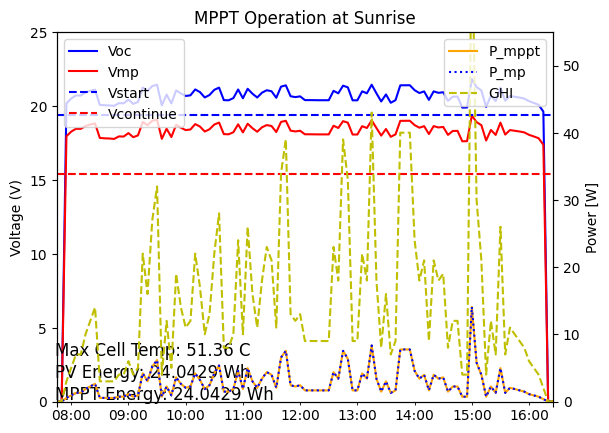

In [47]:
# Create a time delta of 15 minutes
delta = pd.Timedelta(minutes=60)
offset = pd.Timedelta(minutes=2)

# Calculate the start and end of the range
#start = sunrise + offset - delta
#end = sunrise 
start = sunrise - offset
end = sunrise + delta
start = sunrise
end = sunset

# Slice the DataFrame
ac_slice = mc.results.ac.loc[start:end]
dc_slice = mc.results.dc.loc[start:end]
cell_temp_slice = mc.results.cell_temperature.loc[start:end]
air_temp_slice = weather['temp_air'].loc[start:end]
irradiance_slice = mc.results.effective_irradiance.loc[start:end]

# Create a plot of the sliced DataFrame
fig, ax = plt.subplots()

# Plot v_oc and v_mp with specified colors and labels
dc_slice['v_oc'].plot(ax=ax, color='b', label='Voc')
dc_slice['v_mp'].plot(ax=ax, color='r', label='Vmp')

plt.title('MPPT Operation at Sunrise')

# Plot a vertical line at sunrise with a specified label
#ax.axvline(sunrise, color='g', linestyle='--', label='Sunrise')

# Plot a horizontal v_start and v_continue with a specified label
ax.axhline(mppt_parameters['v_batt'] + mppt_parameters['v_start_delta'], color='b', linestyle='--', label='Vstart')
ax.axhline(mppt_parameters['v_batt'] + mppt_parameters['v_continue_delta'], color='r', linestyle='--', label='Vcontinue')

# get max cell temerature

#calculate delta in over that period
dc_energy = dc_slice['p_mp'].sum()*5/60
mppt_energy = ac_slice.sum()*5/60

# add text to plot to show energy
plt.text(sunrise, 3.1, f"Max Cell Temp: {max_cell_temp:.2f} C", fontsize=12)
plt.text(sunrise, 1.6, f"PV Energy: {dc_energy:.4f} Wh", fontsize=12)
plt.text(sunrise, 0.1, f"MPPT Energy: {mppt_energy:.4f} Wh", fontsize=12)

# label the first y axis
ax.set_ylabel('Voltage (V)')

# Create a second Axes object that shares the x-axis with the first
ax2 = ax.twinx()

# Plot the power on the second Axes with a specified color and label
ac_slice.plot(ax=ax2, color='orange', label='P_mppt')
dc_slice['p_mp'].plot(ax=ax2, color='blue', label='P_mp', linestyle=':')
# cell_temp_slice.plot(ax=ax2, color='k', label='Cell Temp', linestyle='--')
# air_temp_slice.plot(ax=ax2, color='g', label='Air Temp', linestyle='--')

# Plot GHI on the second Axes with a specified color and label
irradiance_slice.plot(ax=ax2, color='y', label='GHI', linestyle='--')

# Add a label to the second y-axis
ax2.set_ylabel('Power [W]')

# Add a legend to each Axes
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set the y-axis limits for each Axes
ax2.set_ylim(0, 55)
ax.set_ylim(0, 25)

# Show the plot
plt.show()
